In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install tensorboard
# !pip install tqdm

# resnet

1.Introduction

ResNet, short for Residual Network, is a convolutional neural network introduced by Microsoft Research in 2015. The main innovation of ResNet is the use of residual connections, which allows the network to learn deeper architectures than traditional CNNs.

A residual connection is a shortcut connection that skips one or more layers and connects the input of one layer directly to the output of a layer further down in the network. This allows the network to learn the residual mapping between the input and output of the skipped layer rather than the mapping itself.

The original ResNet architecture, called ResNet-50, had 50 layers and was trained on the ImageNet dataset, achieving state-of-the-art results at the time of release. Since then, several variants of the ResNet architecture have been proposed, such as ResNet-101, ResNet-152, and ResNet-200, with more layers, and ResNet-18, with a smaller version of 18 layers.

ResNet has been widely used in many computer vision tasks, such as image classification, object detection, semantic segmentation, etc. It is also a popular choice for transfer learning, where pre-trained ResNet models can be fine-tuned for different tasks with relatively small datasets.



2.Detail

Next, I will introduce in detail what the code of each box does

import and add name

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from net import *
from PIL import Image


import torch.nn.functional as F
import torch.nn as nn
from util import get_transform, get_acc


The SummaryWriter class is used to write TensorFlow summary data to a specified directory, which can be visualized in TensorBoard. The batch size, learning rate, weight decay and number of epochs are hyperparameters that control the training process of the model.

In [50]:
writer = SummaryWriter ('tf_logs_exp') 
batch_Size = 32
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 20


 Define the model used

In [52]:
#model = get_resnext() 
#model = get_resnet()
model = get_resnet18()


The build up image of resnet

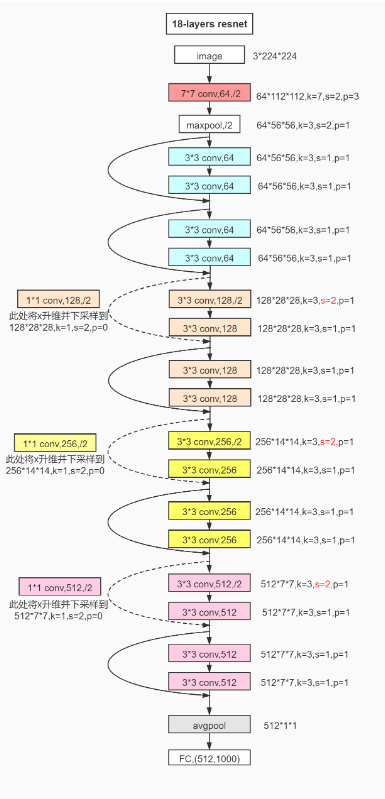

In [53]:
from IPython.display import Image
Image("resnetbuildup.PNG")

Define the name of the training weights of the saved model

In [55]:
#model_path = r'model_save/resnet.pth' 
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'

In [56]:
get_resnet18

<function net.get_resnet18()>

Use gpu if not can use cpu.
 using a GPU with CUDA is generally better for machine learning and deep learning tasks because it allows for faster processing of large amounts of data in parallel, and it is also more versatile and easier to use than other GPU programming frameworks.

In [58]:
def get_device():
    return 'cuda' if torch.cuda.is_available () else 'cpu'

Check if gpu is used correctly

In [59]:
device = get_device ()
print (device)

cuda


Import the correct address for train and valid

In [60]:
model = model.to (device)
train_path = r'dataset/train'
val_path = r'dataset/valid'

Do a transform on the data

In [62]:
# transforms_train = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

# transforms_vaild = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

train_dataset = torchvision.datasets.ImageFolder (root=train_path, transform=get_transform())
val_dataset = torchvision.datasets.ImageFolder (root=val_path, transform=get_transform())

print ('The dataset corresponding labels are:{}'.format (train_dataset.class_to_idx))

The dataset corresponding labels are:{'Albedo': 0, 'CC': 1, 'CuChulainn': 2, 'Gilgamesh': 3, 'Sesshomaru': 4}


Loading the train and validation data in mini-batches using the DataLoader class and it is also shuffling the data at every epoch, to avoid overfitting.
The data will be shuffled at every epoch.2 worker threads will be used to load the data. This can speed up data loading, especially when loading data from disk.

In [64]:
train_loader = DataLoader (dataset=train_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
val_loader = DataLoader (dataset=val_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
print(train_loader,val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x000001EFFF8B3220> <torch.utils.data.dataloader.DataLoader object at 0x000001EFFF8DE140>


In [65]:
len(val_loader)*32

384

In [66]:
batch_images, batch_labels=next(iter(train_loader))

In [67]:
print(f"Image shape: {batch_images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {batch_labels.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [69]:
class_name=train_dataset.classes

In [70]:
class_name

['Albedo', 'CC', 'CuChulainn', 'Gilgamesh', 'Sesshomaru']

C:\Users\21083\AppData\Local\Temp\ipykernel_38572\2439748209.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))


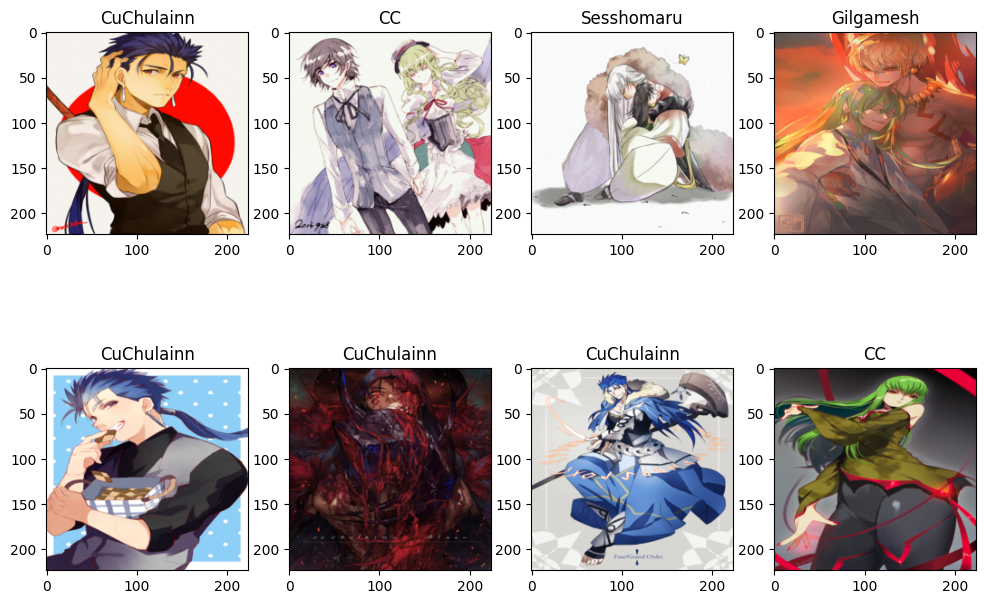

In [71]:
plt.figure(figsize=(12,8))

for i in range(8):
    plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))
    plt.subplot(2,4,i+1)
    plt.title(class_name[batch_labels[i]])
    plt.imshow(plot_img)     

Define cross-entropy loss function, adam optimizer, cos cosine learning rate adjustment

In [72]:

criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.Adam (model.parameters (), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR (optimizer, T_max=10, eta_min=0, last_epoch=-1)

n_epochs = num_epoch

best_acc = 0.0

train_acc_list = []
train_loss_list = []

valid_loss_list = []
valid_acc_list = []


Start training

In [20]:

for epoch in tqdm(range(n_epochs)):

    model.train ()
    train_loss = []
    train_accs = []

    i = 0

    for batch in tqdm (train_loader):

        imgs, labels = batch
        imgs = imgs.to (device)
        labels = labels.to (device)
        logits = model (imgs)
        # Calculate loss
        loss = criterion (logits, labels)

        # Network Updates
        optimizer.zero_grad ()
        loss.backward ()
        optimizer.step ()
        scheduler.step ()

        #if (i % 500 == 0):
            #print ("learning_rate:", scheduler.get_last_lr ()[0])
       # i = i + 1

        acc = (logits.argmax (dim=-1) == labels).float ().mean ()

        train_loss.append (loss.item ())
        train_accs.append (acc.item ())

    train_loss = sum (train_loss) / len (train_loss)
    train_acc = sum (train_accs) / len (train_accs)

    print (f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    train_acc_list.append (train_acc)
    train_loss_list.append (train_loss)
    

    # Record to tensorboard
    writer.add_scalar ('Train Loss ', train_acc, epoch)
    writer.add_scalar ('Train Accuracy ', train_loss, epoch)

    #Validation
    model.eval ()

    valid_loss = []
    valid_accs = []

    for batch in tqdm (val_loader):
        imgs, labels = batch

        with torch.no_grad ():
            logits = model (imgs.to (device))

        loss = criterion (logits, labels.to (device))

        acc = (logits.argmax (dim=-1) == labels.to (device)).float ().mean ()

        valid_loss.append (loss.item ())
        valid_accs.append (acc)

    valid_loss = sum (valid_loss) / len (valid_loss)
    valid_acc = sum (valid_accs) / len (valid_accs)

    print (f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    valid_loss_list.append (valid_loss)
    valid_acc_list.append (valid_acc)

    #Keep the best model on the validation set
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save (model.state_dict (), model_path)
        print ('saving model with acc {:.3f}'.format (best_acc))

    writer.add_scalar ('Valid Loss ', valid_acc, epoch)
    writer.add_scalar ('Valid Accuracy ', valid_loss, epoch)


100%|██████████| 57/57 [01:24<00:00,  1.49s/it]


[ Train | 001/020 ] loss = 1.23419, acc = 0.54776


  5%|▌         | 1/20 [01:38<31:14, 98.67s/it]

[ Valid | 001/020 ] loss = 1.30710, acc = 0.46146
saving model with acc 0.461


100%|██████████| 57/57 [01:09<00:00,  1.22s/it]


[ Train | 002/020 ] loss = 1.03467, acc = 0.62128


 10%|█         | 2/20 [02:58<26:19, 87.77s/it]

[ Valid | 002/020 ] loss = 1.23181, acc = 0.51684
saving model with acc 0.517


100%|██████████| 57/57 [01:09<00:00,  1.22s/it]


[ Train | 003/020 ] loss = 0.89323, acc = 0.67221


 15%|█▌        | 3/20 [04:17<23:43, 83.72s/it]

[ Valid | 003/020 ] loss = 0.84891, acc = 0.71736
saving model with acc 0.717


100%|██████████| 57/57 [01:13<00:00,  1.28s/it]


[ Train | 004/020 ] loss = 0.84766, acc = 0.68488


 20%|██        | 4/20 [05:43<22:32, 84.52s/it]

[ Valid | 004/020 ] loss = 1.03427, acc = 0.66007


100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


[ Train | 005/020 ] loss = 0.77597, acc = 0.71564


 25%|██▌       | 5/20 [07:03<20:41, 82.74s/it]

[ Valid | 005/020 ] loss = 1.82936, acc = 0.39566


100%|██████████| 57/57 [01:14<00:00,  1.30s/it]


[ Train | 006/020 ] loss = 0.73656, acc = 0.72886


 30%|███       | 6/20 [08:27<19:25, 83.26s/it]

[ Valid | 006/020 ] loss = 1.33774, acc = 0.56233


100%|██████████| 57/57 [01:11<00:00,  1.26s/it]


[ Train | 007/020 ] loss = 0.68896, acc = 0.75859


 35%|███▌      | 7/20 [09:48<17:55, 82.72s/it]

[ Valid | 007/020 ] loss = 1.10209, acc = 0.65747


100%|██████████| 57/57 [01:11<00:00,  1.26s/it]


[ Train | 008/020 ] loss = 0.60497, acc = 0.77723


 40%|████      | 8/20 [11:10<16:27, 82.32s/it]

[ Valid | 008/020 ] loss = 1.03239, acc = 0.64601


100%|██████████| 57/57 [01:09<00:00,  1.21s/it]


[ Train | 009/020 ] loss = 0.55784, acc = 0.78661


 45%|████▌     | 9/20 [12:30<14:57, 81.60s/it]

[ Valid | 009/020 ] loss = 0.89408, acc = 0.70503


100%|██████████| 57/57 [01:11<00:00,  1.26s/it]


[ Train | 010/020 ] loss = 0.43644, acc = 0.84095


 50%|█████     | 10/20 [13:53<13:39, 81.98s/it]

[ Valid | 010/020 ] loss = 1.14162, acc = 0.64375


100%|██████████| 57/57 [01:14<00:00,  1.31s/it]


[ Train | 011/020 ] loss = 0.36972, acc = 0.87786


 55%|█████▌    | 11/20 [15:17<12:23, 82.59s/it]

[ Valid | 011/020 ] loss = 1.37676, acc = 0.60764


100%|██████████| 57/57 [00:47<00:00,  1.21it/s]


[ Train | 012/020 ] loss = 0.33366, acc = 0.87360


 60%|██████    | 12/20 [16:14<09:59, 74.99s/it]

[ Valid | 012/020 ] loss = 2.58294, acc = 0.47083


100%|██████████| 57/57 [00:40<00:00,  1.41it/s]


[ Train | 013/020 ] loss = 0.29943, acc = 0.89620


 65%|██████▌   | 13/20 [17:05<07:53, 67.62s/it]

[ Valid | 013/020 ] loss = 1.27935, acc = 0.59201


100%|██████████| 57/57 [00:40<00:00,  1.40it/s]


[ Train | 014/020 ] loss = 0.19869, acc = 0.93311


 70%|███████   | 14/20 [17:56<06:15, 62.51s/it]

[ Valid | 014/020 ] loss = 1.23754, acc = 0.63594


100%|██████████| 57/57 [00:42<00:00,  1.34it/s]


[ Train | 015/020 ] loss = 0.15540, acc = 0.94846


 75%|███████▌  | 15/20 [18:48<04:57, 59.52s/it]

[ Valid | 015/020 ] loss = 0.97197, acc = 0.71510


100%|██████████| 57/57 [00:41<00:00,  1.38it/s]


[ Train | 016/020 ] loss = 0.12261, acc = 0.95955


 80%|████████  | 16/20 [19:40<03:48, 57.03s/it]

[ Valid | 016/020 ] loss = 0.94808, acc = 0.71962
saving model with acc 0.720


100%|██████████| 57/57 [00:39<00:00,  1.44it/s]


[ Train | 017/020 ] loss = 0.09871, acc = 0.96985


 85%|████████▌ | 17/20 [20:29<02:44, 54.72s/it]

[ Valid | 017/020 ] loss = 0.97079, acc = 0.73924
saving model with acc 0.739


100%|██████████| 57/57 [00:40<00:00,  1.40it/s]


[ Train | 018/020 ] loss = 0.03384, acc = 0.99245


 90%|█████████ | 18/20 [21:23<01:48, 54.41s/it]

[ Valid | 018/020 ] loss = 1.17170, acc = 0.68385


100%|██████████| 57/57 [01:05<00:00,  1.14s/it]


[ Train | 019/020 ] loss = 0.01505, acc = 0.99671


 95%|█████████▌| 19/20 [22:42<01:01, 61.95s/it]

[ Valid | 019/020 ] loss = 1.14684, acc = 0.68472


100%|██████████| 57/57 [00:59<00:00,  1.05s/it]


[ Train | 020/020 ] loss = 0.02110, acc = 0.99409


100%|██████████| 20/20 [23:55<00:00, 71.78s/it]

[ Valid | 020/020 ] loss = 1.04068, acc = 0.70955


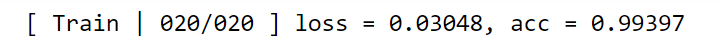

In [73]:
Image("20epochtrain.PNG")

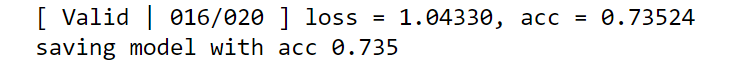

In [74]:
Image("20epochvalid.PNG")

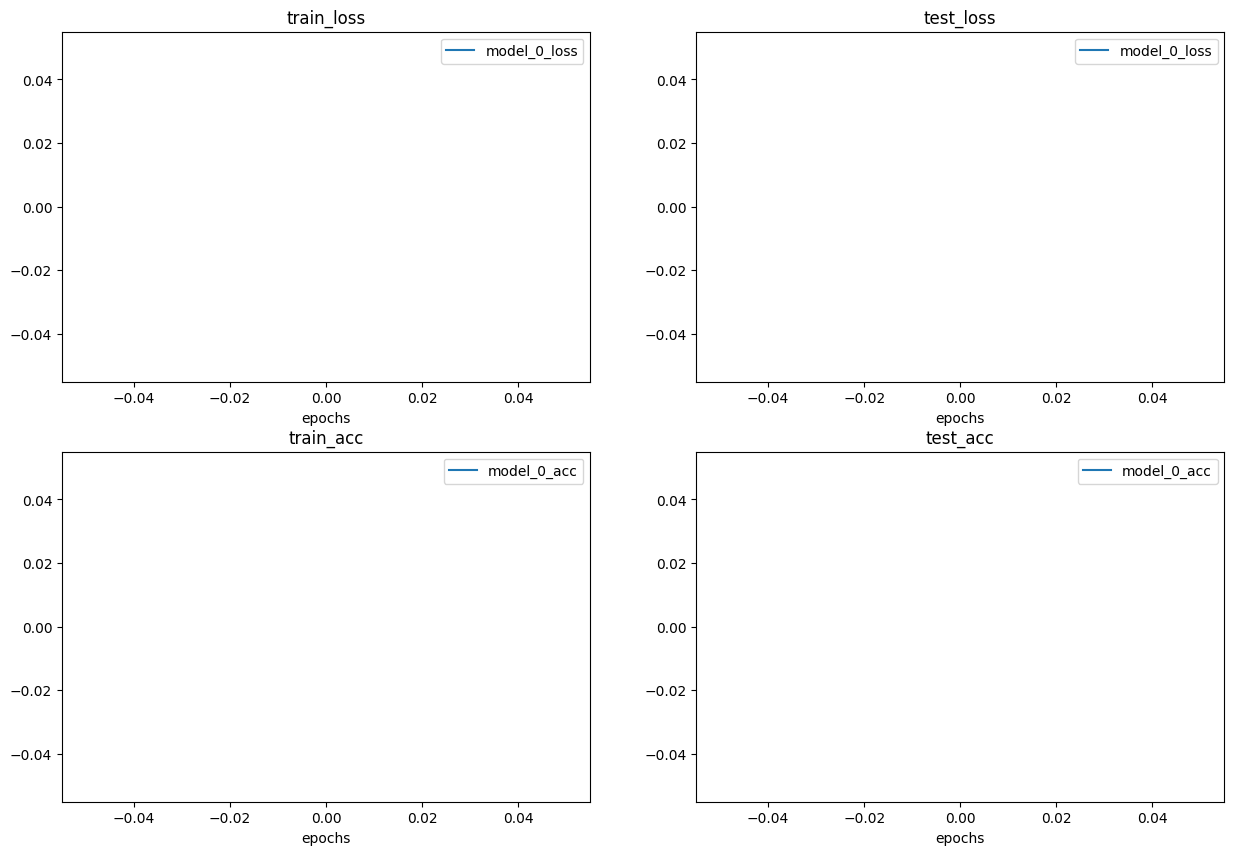

In [75]:
# ------ Complete subplot functions in the following lines -------
plt.figure(figsize=(15, 10))

# Plot train loss with label, title, legend
plt.subplot(2, 2, 1)
plt.plot(train_acc_list,label='model_0_loss')  
plt.title('train_loss')
plt.xlabel('epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_list,label='model_0_loss')  
plt.title('test_loss')
plt.xlabel('epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(valid_loss_list,label='model_0_acc') 
plt.title('train_acc')
plt.xlabel('epochs')
plt.legend()

valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())
    
# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(valid_accuracy_list,label='model_0_acc')   

plt.title('test_acc')
plt.xlabel('epochs')
plt.legend()


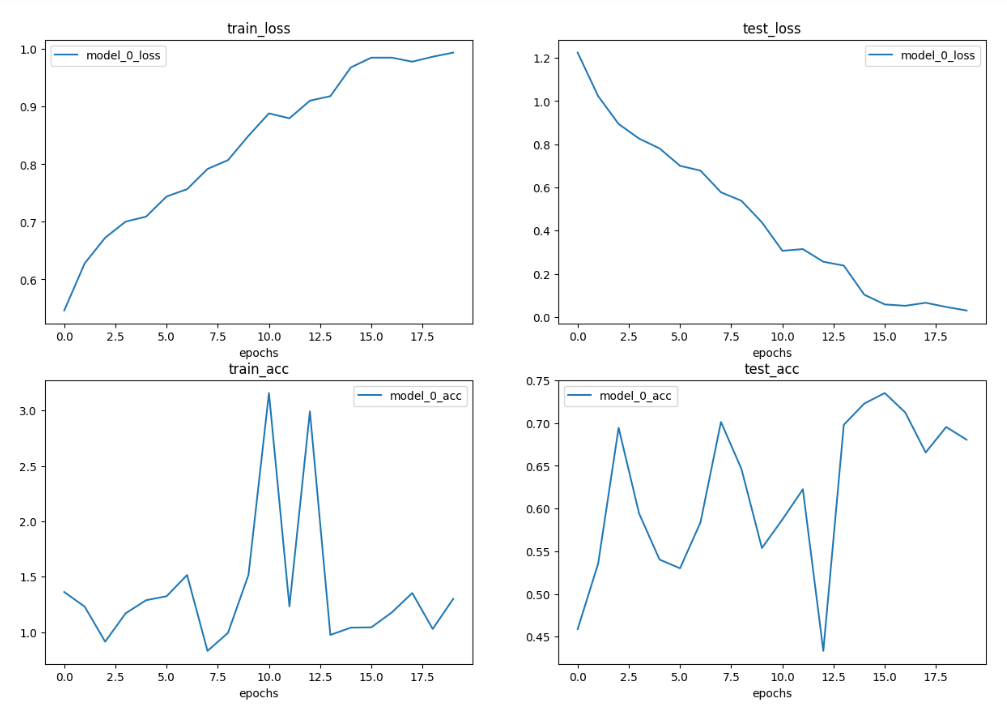

In [24]:
Image("20epochplt.PNG")

In [76]:
valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())

In [77]:
valid_accuracy_list

[]

Build the model and read the trained weights. First define the model to be used, and then define the name to save the model training weights

In [78]:


#model = get_resnext()
#model = get_resnet()
model = get_resnet18()
#model_path = r'model_save/resnet.pth'
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'


In [79]:
test_path = r'dataset/test'


test_dataset = torchvision.datasets.ImageFolder (root=test_path, transform=get_transform())

test_loader = DataLoader (dataset=test_dataset, batch_size=32, shuffle=True)

In [80]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear (num_ftrs, 5)
model.load_state_dict (torch.load (model_path))
model = model.to (device)

criterion = nn.CrossEntropyLoss ()

model.eval ()
test_loss = []
test_accs = []


In [81]:
test_acc = get_acc(model, test_loader, criterion)
print (f"Test  acc = {test_acc:.5f}")

100%|██████████| 12/12 [00:23<00:00,  1.92s/it]

Test  acc = 0.68953


Predict a single image and add a one-dimensional batch

Build the model and read the trained weights，Show the names of the predicted images as text

Show the names of the predicted images as images

In [89]:
import os
import torch
from PIL import Image
from torchvision import transforms
from net import *


def get_device():
    return 'cuda' if torch.cuda.is_available () else 'cpu'


def model_test(model, img_path):
    device = 'cuda'
    data_transform = transforms.Compose ([
        transforms.Resize ((224, 224)),
        transforms.ToTensor (),
    ])

    img = Image.open (img_path)
    img = data_transform (img)

    img = torch.unsqueeze (img, dim=0)

    model.eval ()
    with torch.no_grad ():
        output = model (img.to (device))
        number = torch.argmax (output.to ('cpu')[0]).numpy ().item ()

    return number


if __name__ == '__main__':

    model = get_resnet18 ()
    device = get_device ()
    model.to (device)

    model_path = r'model_save/resnet18.pth'
    model.load_state_dict (torch.load (model_path))

  
    label_dict = {0:'Albedo', 1:'CC', 2:'CuChulainn', 3:'Gilgamesh', 4:'Sesshomaru'}
    img_pre_labels=[]
    count = 0
    for i in os.listdir(r'prediction'):
        img_path = r'prediction'+'/'+i
        img_pre_label = label_dict [model_test (model, img_path)]
        img_pre_labels.append(img_pre_label)

        print ('picture {} name is： {}'.format(i,img_pre_labels[count]))
        count+=1


picture 2.jpg name is： Sesshomaru
picture 3.jpg name is： Sesshomaru
picture 4.jpg name is： Sesshomaru
picture 5.jpg name is： Albedo
picture 6.png name is： CC
picture 7.png name is： CC
picture 8.jpg name is： Gilgamesh


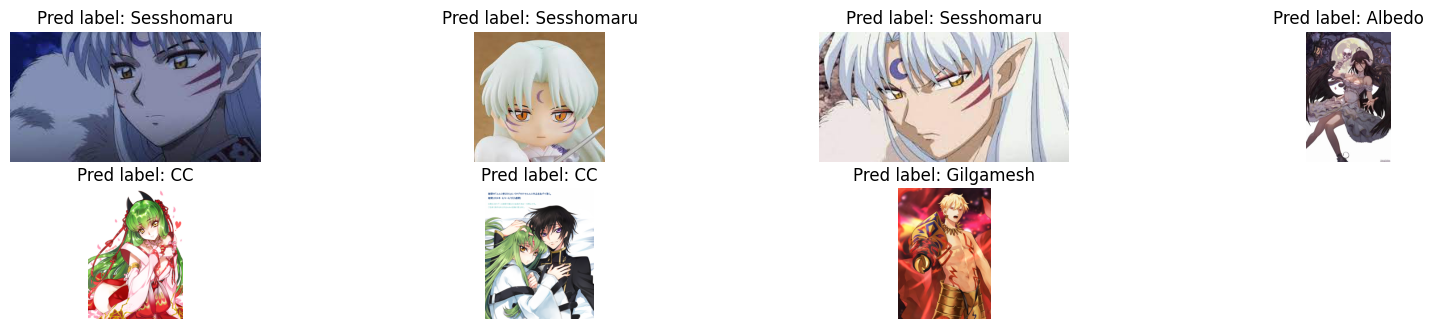

In [45]:
plt.figure(figsize=[20,20])    
count1=1
for i in os.listdir(r'prediction'):
        custom_image = r'prediction'+'/'+ i
        img = torchvision.io.read_image(custom_image)
        plt.subplot(10,4,count1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred label: {img_pre_labels[count1-1]}")
        plt.axis(False)
        count1+=1